## Work on real Merian image
1. Most things are the same in the previous notebook `Merian-tractor-SEP-blob-by-blob.ipynb`.

2. The image `c4d_210307_021334_osj_N708_wide.fits` is not background-subtracted. In `Merian-raw-data-process.ipynb`, I (roughly) estimated a background and subtracted. I think we should discuss about background subtraction & flux calibration in more details.

3. In order to fit Merian data with HSC i-band as reference, the i-band output source should be translated to Merian pixel_scale/zeropoint/etc. 

4. I made some updates to `kuaizi.tractor.utils.tractor_blob_by_blob`. Now we can freeze only "b/a" and "position angle" but not effective radius when fitting. In order to do this, use `freeze_dict={'pos': False, 'shape.ab': True, 'shape.phi': True, 'shape.re': False, sersicindex': True}`. 

5. The Merian N708 filter is dubbed as `N`. To get the fitting results, use `model_dict['N']` and `getTargetProperty(model_dict['N'], wcs=merian_data.wcs, pixel_scale=0.27, zeropoint=27)`. 

#### Notes on data
Directory: `/tigress/MERIAN/merian/cosmos_stack`

Suffix: image (`osj`), data quality (`osd`), and weights (`osw`)

Cutout is made in `Merian-raw-data-process.ipynb`

In [4]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
obj_cat = Table.read('/Users/jiaxuanli/Research/Merian/cosmos_test_1/cosmos_test_1-2021-02-04.fits')

### Step-by-step

In [6]:
from astropy.convolution import Gaussian2DKernel

In [7]:
channels = 'grizy'

obj = obj_cat[0]
obj_id = obj['name'].lstrip('s18a_wide').rstrip('_y')

cutout = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
    ) for filt in 'grizy'
]

psf_list = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
    ) for filt in 'grizy'
]

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

In [8]:
# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
hsc_data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels) #  
# `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy

merian_hdu = fits.open('../cosmos_test_1/1/226984/merian/merian_226984_N708.fits')
merian_data = Data(images=merian_hdu[1].data[np.newaxis, :, :], 
                   weights=merian_hdu[3].data[np.newaxis, :, :], 
                   wcs=wcs.WCS(merian_hdu[1].header), 
                   psfs=[merian_hdu[4].data], channels='N')

Text(0.5, 1.0, 'Merian N708')

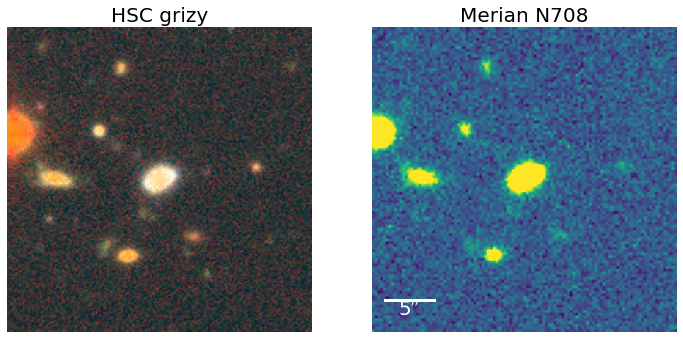

In [10]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(5)

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 12))

ax1.imshow(img_rgb, origin='lower', alpha=1)
ax1.axis('off')
ax1.set_title('HSC grizy', fontsize=20)

ax2 = display_single(merian_data.images[0], ax=ax2, pixel_scale=0.27)
ax2.axis('off')
ax2.set_title('Merian N708', fontsize=20)

In [11]:
from kuaizi.tractor.utils import makeCatalog, tractor_hsc_sep_blob_by_blob, getTargetProperty

### `s18a_wide_226984` i-band
    Detected 18 objects
# Total number of objects: 18
# Central object index in i-band: 1


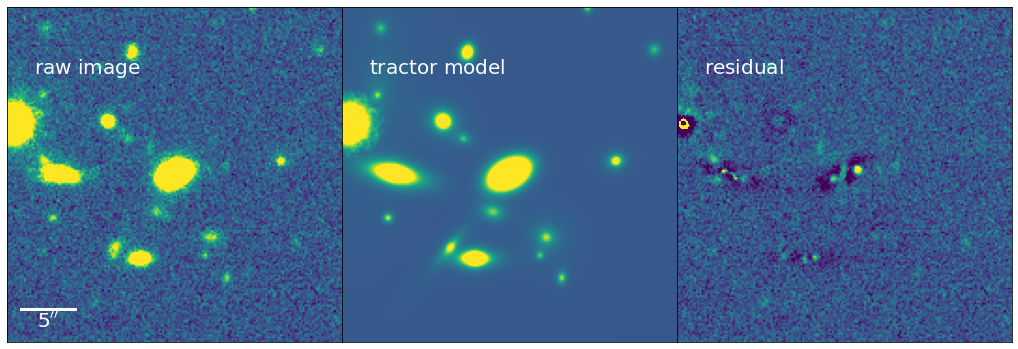

   The chi-square is 49943.07
SersicGalaxy at pixel (88.79, 89.36) with Flux: 413.106 and Galaxy Shape: re=1.05, ab=0.55, phi=117.1, Sersic index 0.761


In [12]:
# Start fitting
# fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
model_dict = {}

ref_filt = 'i'
model_dict[ref_filt] = tractor_hsc_sep_blob_by_blob(
    obj, ref_filt, hsc_data.channels, hsc_data, 
    freeze_dict={'pos': False, 'shape': False, 'sersicindex': False}, # don't fix shape/sersic
    verbose=False)

In [13]:
import copy
ref_source = copy.deepcopy(model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind])

# Translate HSC coordinates into Merian coordinates
x, y = merian_data.wcs.wcs_world2pix(*hsc_data.wcs.wcs_pix2world(ref_source.pos.x, ref_source.pos.y, 0), 0)
ref_source.pos.x = float(x)
ref_source.pos.y = float(y)
ref_source.shape.re *= 0.168 / 0.27 # to Merian pixel scale

### `s18a_wide_226984` N-band
    Detected 6 objects
# Total number of objects: 6
# Central object index in N-band: 1
# Progress: 0 / 6
# Progress: 1 / 6
# Progress: 2 / 6
# Progress: 3 / 6
# Progress: 4 / 6
# Progress: 5 / 6


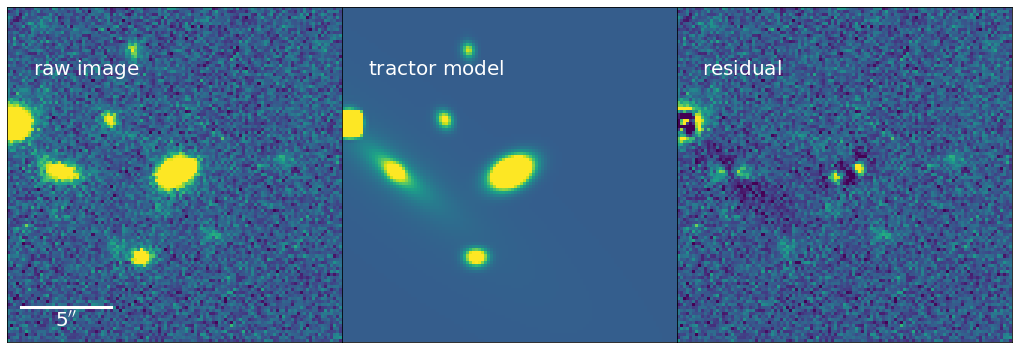

   The chi-square is 0.00016933095
SersicGalaxy at pixel (55.40, 56.31) with Flux: 1.6421 and Galaxy Shape: re=0.71, ab=0.55, phi=117.1, Sersic index 0.761


In [14]:
model_dict['N'] = tractor_hsc_sep_blob_by_blob(
        obj, 'N', merian_data.channels, merian_data, 
        ref_source=ref_source,
        freeze_dict={'pos': False, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
        # Since the coordinate system of Merian is different from HSC, we don't fix position. 
        verbose=True)

# Batch fitting (forced-photometry, blob-by-blob)

### `s18a_wide_238189` i-band
    Detected 13 objects
# Total number of objects: 13
# Central object index in i-band: 0


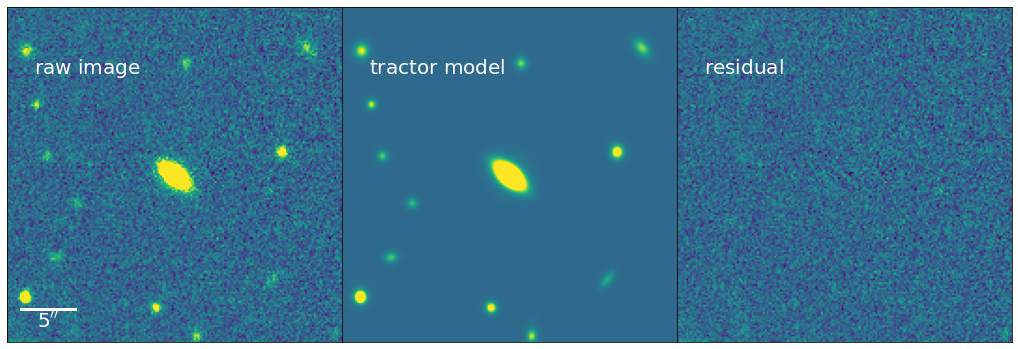

   The chi-square is 31312.014
SersicGalaxy at pixel (89.18, 88.37) with Flux: 231.732 and Galaxy Shape: re=0.73, ab=0.35, phi=49.9, Sersic index 1.257
### `s18a_wide_238189` g-band
    Detected 9 objects
# Total number of objects: 9
# Central object index in g-band: 0


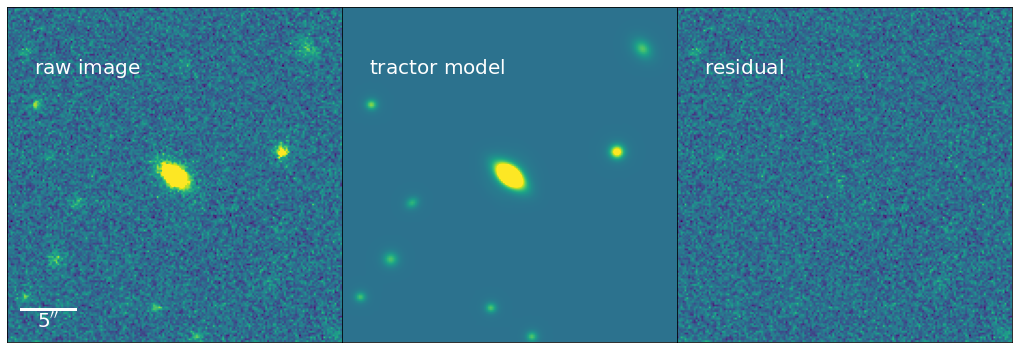

   The chi-square is 32280.84
SersicGalaxy at pixel (89.18, 88.37) with Flux: 82.3524 and Galaxy Shape: re=0.73, ab=0.35, phi=49.9, Sersic index 1.257
### `s18a_wide_238189` r-band
    Detected 9 objects
# Total number of objects: 9
# Central object index in r-band: 0


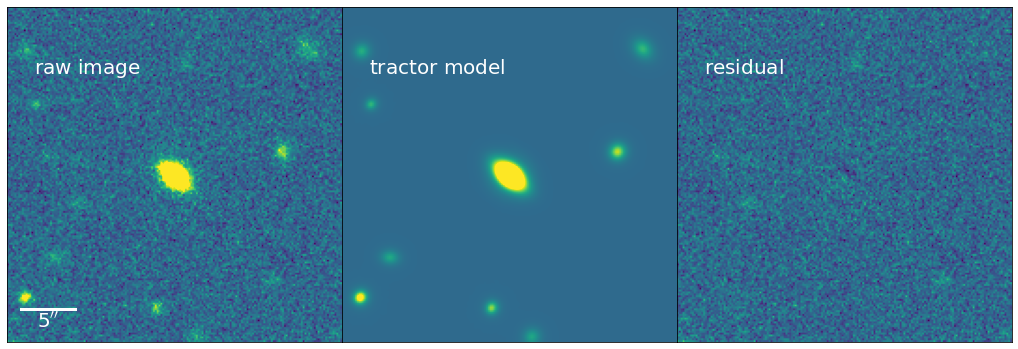

   The chi-square is 32248.41
SersicGalaxy at pixel (89.18, 88.37) with Flux: 164.37 and Galaxy Shape: re=0.73, ab=0.35, phi=49.9, Sersic index 1.257
### `s18a_wide_238189` z-band
    Detected 7 objects
# Total number of objects: 7
# Central object index in z-band: 0


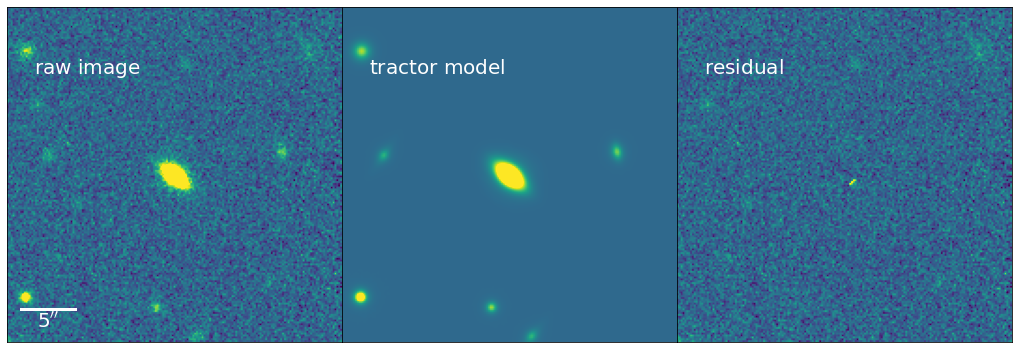

   The chi-square is 32251.203
SersicGalaxy at pixel (89.18, 88.37) with Flux: 290.644 and Galaxy Shape: re=0.73, ab=0.35, phi=49.9, Sersic index 1.257
### `s18a_wide_238189` y-band
    Detected 5 objects
# Total number of objects: 5
# Central object index in y-band: 0


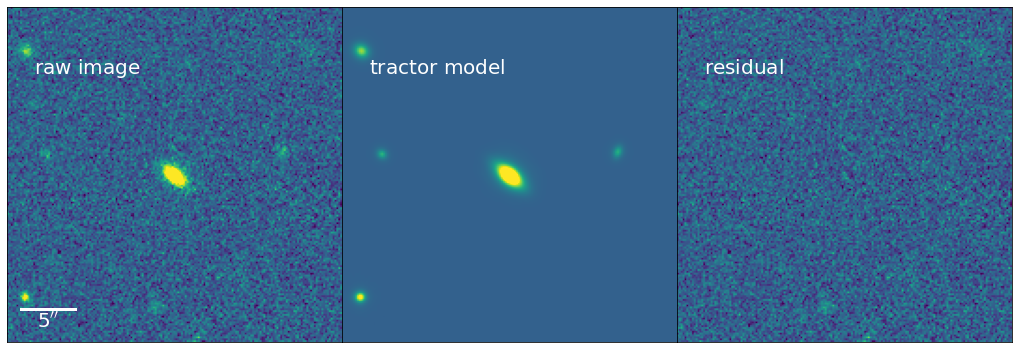

   The chi-square is 32037.121
SersicGalaxy at pixel (89.18, 88.37) with Flux: 321.762 and Galaxy Shape: re=0.73, ab=0.35, phi=49.9, Sersic index 1.257
### `s18a_wide_238189` N-band
    Detected 3 objects
# Total number of objects: 3
# Central object index in N-band: 0


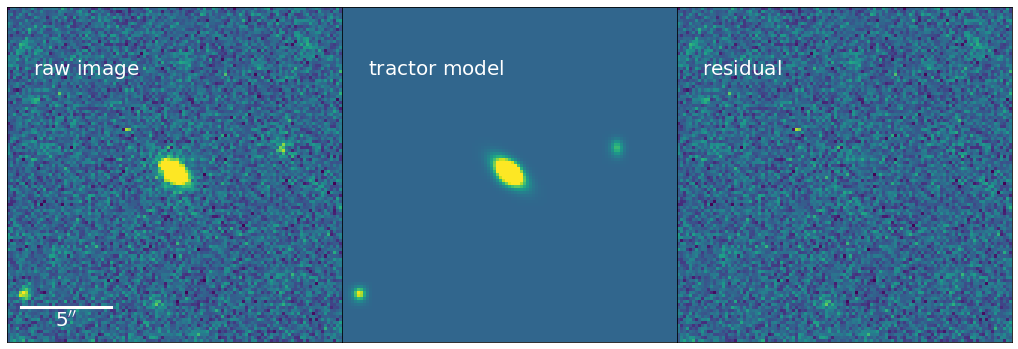

   The chi-square is 0.00012420726
SersicGalaxy at pixel (54.92, 55.89) with Flux: 0.707868 and Galaxy Shape: re=0.49, ab=0.35, phi=49.9, Sersic index 1.257


In [24]:
channels = 'grizy'
ref_filt = 'i'
forced_channels = [filt for filt in channels if filt != ref_filt]

for obj in obj_cat[2:3]:
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('s18a_wide')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    cutout = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
        ) for filt in channels
    ]
    psf_list = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
        ) for filt in channels
    ]

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    hsc_data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy
    merian_hdu = fits.open(f'../cosmos_test_1/1/{obj_id}/merian/merian_{obj_id}_N708.fits')
    merian_data = Data(images=merian_hdu[1].data[np.newaxis, :, :], 
                       weights=merian_hdu[3].data[np.newaxis, :, :], 
                       wcs=wcs.WCS(merian_hdu[1].header), 
                       psfs=[merian_hdu[4].data], channels='N')
    
    # Start fitting
    model_dict = {}
    
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands 
    model_dict[ref_filt] = tractor_hsc_sep_blob_by_blob(
        obj, ref_filt, hsc_data.channels, hsc_data, 
        freeze_dict={'pos': False, 'shape': False, 'sersicindex': False}, # don't fix shape/sersic
        verbose=False)

    for filt in forced_channels:
        model_dict[filt] = tractor_hsc_sep_blob_by_blob(
            obj, filt, hsc_data.channels, hsc_data, 
            ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
            freeze_dict={'pos': True, 'shape': True, 'sersicindex': True}, # don't fix shape/sersic
            verbose=False)
        
    # Fitting for Merian image. Translate HSC coordinates into Merian coordinates
    ref_source = copy.deepcopy(model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind])
    x, y = merian_data.wcs.wcs_world2pix(*hsc_data.wcs.wcs_pix2world(ref_source.pos.x, ref_source.pos.y, 0), 0)
    ref_source.pos.x = float(x)
    ref_source.pos.y = float(y)
    ref_source.shape.re *= 0.168 / 0.27 # to Merian pixel
    
    model_dict['N'] = tractor_hsc_sep_blob_by_blob(
        obj, 'N', merian_data.channels, merian_data, 
        ref_source=ref_source,
        freeze_dict={'pos': False, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
        # Since the coordinate system of Merian is different from HSC, we don't fix position. 
        verbose=False)
    
    with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
    

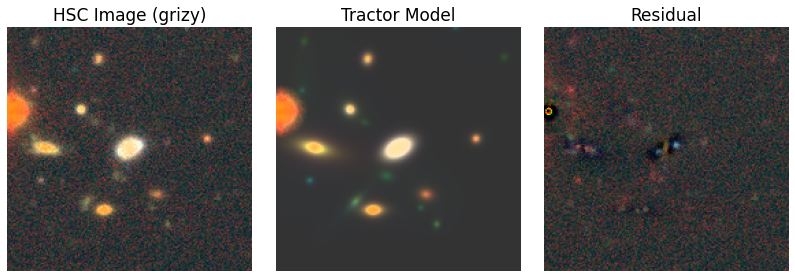

In [307]:
# ### Make figures into a PDF file (slow)
# from fpdf import FPDF
# pdf = FPDF()
# pdf.add_page()
# for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
#     pdf.image(image, 21, 11 + k * 55, 167, 55)
# pdf.output(obj_name + "_sep_tractor.pdf", "F")

# Visualize our model
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

model_rgb = scarlet.display.img_to_rgb(
    model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

res_rgb = scarlet.display.img_to_rgb(
    hsc_data.images - model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
ax1.imshow(img_rgb, origin='lower')
ax2.imshow(model_rgb, origin='lower')
ax3.imshow(res_rgb, origin='lower')

for ax in [ax1, ax2, ax3]:
    ax.axis('off')

ax1.set_title('HSC Image (grizy)', fontsize=17)
ax2.set_title('Tractor Model', fontsize=17)
ax3.set_title('Residual', fontsize=17)

plt.subplots_adjust(wspace=0.1)
plt.savefig(obj_name + '_sep_tractor_rgb.png', 
            bbox_inches='tight', 
            metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})


#clear_output()
#plt.close()

### Try some visualization thing: you can ignore things below. Not important now.

In [25]:
def merian_to_green(image):
    # Green
    stack = np.repeat(image, 5, axis=0)
    stack[0] = 0.0
    stack[-1] = 0.0
    stack[1] *= 0.2
    stack[2] *= 0.6
    stack[3] *= 0.2
    
    return stack

In [26]:
from kuaizi.tractor.utils import HiddenPrints
from scipy.ndimage import zoom

with HiddenPrints():
    hsc_model = np.asarray([model_dict[key].getModelImage(0) for key in hsc_data.channels])
    merian_model = np.asarray([model_dict[key].getModelImage(0) for key in merian_data.channels])
    
# Rescale Merian image to HSC size, just for displaying
hsc_size = hsc_data.images.shape[1]
merian_size = merian_data.images.shape[1]

merian_image = zoom(merian_data.images[0], hsc_size / merian_size)[np.newaxis, :, :]
merian_model = zoom(merian_model[0], hsc_size / merian_size)[np.newaxis, :, :]

merian_image = merian_to_green(merian_image) * 30
merian_model = merian_to_green(merian_model) * 30

In [27]:
stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(hsc_data.channels))

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images + merian_image,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

model_rgb = scarlet.display.img_to_rgb(
    hsc_model + merian_model,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)


res_rgb = scarlet.display.img_to_rgb(
    hsc_data.images - hsc_model + (merian_image - merian_model),
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

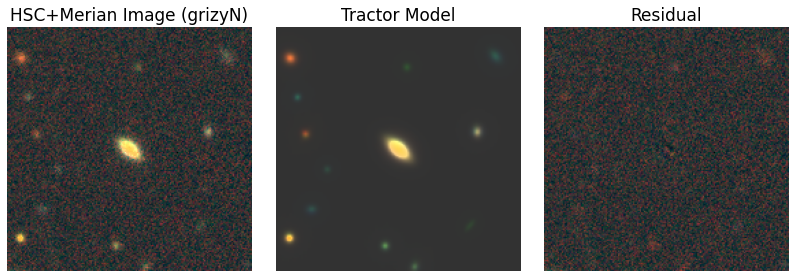

In [28]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
ax1.imshow(img_rgb, origin='lower')
ax2.imshow(model_rgb, origin='lower')
ax3.imshow(res_rgb, origin='lower')

for ax in [ax1, ax2, ax3]:
    ax.axis('off')

ax1.set_title('HSC+Merian Image (grizyN)', fontsize=17)
ax2.set_title('Tractor Model', fontsize=17)
ax3.set_title('Residual', fontsize=17)

plt.subplots_adjust(wspace=0.1)
plt.savefig(obj_name + '_sep_tractor_rgb.png', 
            bbox_inches='tight', 
            metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor and blob-by-blob method'})